<a href="https://colab.research.google.com/github/sarahcburnett/ML_tools/blob/master/Intro_to_Reservoir_Computing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's do some reservoir computing!!


---
Sarah Burnett (2020) commented and modified code Sarthak Chandra gave permission to share. The techniques for reservoir computing here are explained well in the [[2017 paper](https://arxiv.org/abs/1710.07313)] by Jaideep Pathak, et al. 

##Normalize your data

To begin, choose a collection of the data that you want to predict. 
In the example we will make some synthetic data and train on 80% of it.

Let's produce the Lorenz-63' data set. 


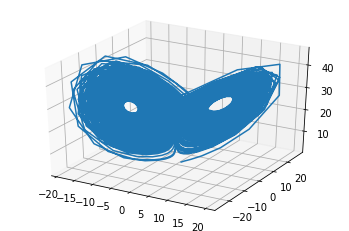

In [1]:
#This was taken from Wikipedia
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

r = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(state, t):
    x, y, z = state  # Unpack the state vector
    return sigma * (y - x), x * (r - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t = np.arange(0.0, 200.0, 0.05)

states = odeint(f, state0, t)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

It's like a butterfly! Lorenz '63 is a simplified model for convective rolls in the atomosphere. Its know for its irregular behavior. 

Select the post-transient. (Check that it's on the attractor/butterfly). 

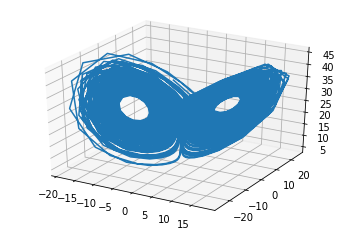

In [2]:
states = states[500:,:]
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states[:, 0], states[:, 1], states[:, 2])
plt.draw()
plt.show()

Normalize the states. Make some noisy data and a truth set.


In [0]:
import pylab as pl

#normalized data
xs=pl.copy(states)
xavg=pl.average(xs,axis=0)
xstd=pl.std(xs,axis=0)
xnlist=(xs-xavg)/xstd

#save noiseless as the truth
xnlistnoiseless=pl.copy(xnlist)

#add noise
xnlist=xnlist+pl.normal(0,0.015,xnlist.shape)

##Meet the Reservoir Map

Below is a list of functions used for reservoir computing. The first function listed is the reservoir map

$$\mathbf{r}(t+ \Delta t) = \tanh \left[ \mathbf{A} \mathbf{r} (t) + \mathbf{W}_{in}  \mathbf{W}_{out}(\mathbf{r}(t),\mathbf{P}) \right]. $$

with the python function below it includes a leakage parameter. 


In [0]:
def reservoirmap(rn,inp,A,Win,leakage=0.):
    return leakage*rn + (1.-leakage)*pl.tanh(dot(Win,inp) + dot(A,rn))

def dot(a,b):
    return a*b

Define the leakage here. You can think of it as the regulating the amount of linear change in the reservoir. When leakage = 0, we have no leakage, the reservoir is capable of making a large adjustment. When leakage = 1, there is all leakage and no change in the reservoir. It becauses a linear update with

$$\mathbf{v}(t+\Delta t)=\mathbf{W}_{o u t}(\mathbf{r}(t+\Delta t), \mathbf{P}).$$

now just

$$\mathbf{v}(t+\Delta t)=\mathbf{W}_{o u t}(\mathbf{W}_{in}\mathbf{u}(t), \mathbf{P})$$.

Choose leakage below. 

In [0]:
leakage =  0

##Prep your reservoir

Let's meet some parameters.

In [0]:
Dr=2000 #number of reservoir nodes
avd=3 #3 or 5 #Adjacency matrix param, average degree of the reservoir
(L,N)=states.shape
training_transient = 100 
training_length=int(L*.8)-training_transient
testing_length=L-training_length-training_transient
r_tr_step=min(10000,training_length) #reservoir training step for running sum, make it smaller to use less memory instead of computation time

These parameters don't need to be tuned and changed. We like them to remain small so that the computational cost is low. Change Dr and avd if you don't get improvements tuning leakage, rho, and the training period.

The following is a function to create a sparse random matrix with a particular size and average degree of freedom.

In [0]:
import scipy.sparse as sparse
from scipy.sparse import linalg as lalg
from scipy.sparse.linalg import ArpackNoConvergence

def makeAdjMatrix(Dr,avd):
    try: 
        Ao=sparse.lil_matrix((Dr,Dr))
        for _ in range(int(avd*Dr)):
            Ao[pl.randint(0,Dr),pl.randint(0,Dr)]=pl.uniform(-1,1)  
        lambda0=abs(lalg.eigs(Ao,k=1,which='LM',return_eigenvectors=False)[0])
    except ArpackNoConvergence as err: #Don't worry about this
        try: 
            Ao=sparse.lil_matrix((Dr,Dr))
            for _ in range(int(avd*Dr)):
                Ao[pl.randint(0,Dr),pl.randint(0,Dr)]=pl.uniform(-1,1)  
            lambda0=abs(lalg.eigs(Ao,k=1,which='LM',return_eigenvectors=False)[0])
        except ArpackNoConvergence as err:
            if verbose:
                print( "trying again")
            Ao=sparse.lil_matrix((Dr,Dr))
            for _ in range(int(avd*Dr)):
                Ao[pl.randint(0,Dr),pl.randint(0,Dr)]=pl.uniform(-1,1)  
            lambda0=abs(lalg.eigs(Ao,k=1,which='LM',return_eigenvectors=False)[0])    
    return Ao,lambda0

This rho parameter makes the system have more drastic nonlinear updates to the reservoir when receiving new information by modifying the largest eigenvalue of the initialized adjaceny matrix, A. Choose a value start close to 1. (rho = 1 means no scaling). 

In [0]:
rho = 0.9

Initialize the adjacency matrix, $\mathbf{A}$.

In [0]:
Ao,lambda0=makeAdjMatrix(Dr,avd)
A=Ao*rho/lambda0 
A=A.tocsr() 

Initialize the input and output weights, $\mathbf{W}_{in}$. 



In [0]:
Win_sigma=1 #range for uniform distribution, optimize this around 1
Dinp=N

def makeWin(Dr,Dinp,Win_sigma,verbose=True):
    Win=sparse.lil_matrix((Dr,Dinp))
    for i in range(Dr):
        Win[i,pl.randint(0,Dinp)]=pl.uniform(-Win_sigma,Win_sigma)
    return Win

Win=makeWin(Dr,Dinp,Win_sigma)
Win=Win.tocsr()

##Time to train the reservoir!

In this stage, we aim to train our reservoir on a subset of the data that we will call the `measurements', $\mathbf{u}(t)$. These measurements are mapped into the reservoir state space using the $D_r \times D$ matrix $\mathbf{W}_{in}$, where $D_r$ is reservoir dimensions and $D$ is the dimension of the input, 3 for Lorenz '63. Likewise, outputs from the reservoir are mapped back to the same state space as the inputs using the function $\mathbf{W}_{out}(\mathbf{r},\mathbf{P})$, where $\mathbf{r}(t)$ is the reservoir state and $\mathbf{P}$ is a regularization matrix. 

The reservoir is updated/trained by iterating through the measurements and combining them with the reservoir states, giving the new reservoir state and output

\begin{align}
\mathbf{r}(t+ \Delta t) &= \tanh \left[ \mathbf{A} \mathbf{r} (t) + \mathbf{W}_{in} \mathbf{u}(t) \right], \\
\mathbf{v}(t+ \Delta t) &= \mathbf{W}_{out}(\mathbf{r}(t+ \Delta t),\mathbf{P}).
\end{align}

The desired effect we want the reservior to have is that the output $\mathbf{v}(t+ \Delta t)$ be the same as the data, $\mathbf{v}_d(t+ \Delta t)$. We do this by choosing $\mathbf{P}$ such that during the training period of $-T \leq t \leq 0$ the following equation

\begin{equation}
\sum_{-T \leq t \leq 0} \| \mathbf{W}_{out}(\mathbf{r},\mathbf{P}) - \mathbf{v}_d(t+ \Delta t) \|^2 + \beta \|\mathbf{P} \|^2
\end{equation}

is minimized, where $\beta >0$ is a regularization constant. Considering $\mathbf{W}_{out}$ is taken linearly in $\mathbf{P}$, this becomes a linear regression problem and the Tikhonov regularized regression procedure is implemented. 


In [19]:
import scipy.sparse as sparse
from scipy.sparse import linalg as lalg
from scipy.sparse.linalg import ArpackNoConvergence
import sys

if sys.version_info[0]==3:
	xrange=range

def train_reservoir(xnlist,training_transient,training_length,A,Win,leakage,r_tr_step,verbose=True):
    Dr=A.shape[0]
    rn=pl.zeros((Dr))
    reservoir_state_training=pl.zeros((r_tr_step,Dr))
    RTRt=pl.outer(rn,rn)
    RTxt=pl.outer(pl.zeros(Dr),xnlist[0])  #xnlist[0] will go in the sum twice, but doesn't matter because here i've multiplied it with a zeros vector
    for n in xrange(training_transient):
        rn=reservoirmap(rn,xnlist[n],A,Win,leakage)
    for n in xrange(training_length//r_tr_step):
        for m in range(r_tr_step):
            reservoir_state_training[m]=sqeven(rn) #squaring the value of the reservoir state at alternate notes
            rn=reservoirmap(rn,xnlist[r_tr_step*n+m+training_transient],A,Win,leakage)
        RTRt = RTRt + pl.dot(reservoir_state_training.transpose(),reservoir_state_training)
        RTxt = RTxt + pl.dot(reservoir_state_training.transpose(),xnlist[training_transient+r_tr_step*n:training_transient+r_tr_step*(n+1)])
    return rn,RTRt,RTxt,reservoir_state_training
   
def reservoir_prediction(rn,Win,A,Wout,leakage,testing_length):
    Dinp=Wout.shape[1]
    predicted_output=pl.zeros((testing_length,Dinp))
    for n in xrange(testing_length):
        xn_pred=pl.dot(sqeven(rn),Wout)
        predicted_output[n]=xn_pred
        rn=reservoirmap(rn,xn_pred,A,Win,leakage)    
    return predicted_output,rn
    
def sqeven(x):
	x[::2]=x[::2]**2.
	return x


#Train A
rn,RTRt,RTxt,reservoir_state_training=train_reservoir(xnlist,training_transient,training_length,A,Win,leakage,r_tr_step)
print(rn.shape)

#Solve for Wout
Wout=pl.solve((RTRt+beta*pl.eye(Dr)),RTxt)

(2000,)


##Run the reservoir for prediction

The next stage is the prediction phase. The approach [[Jaeger 2004](http://www.columbia.edu/cu/biology/courses/w4070/Reading_List_Yuste/haas_04.pdf)] used is to take the desired output to be equal to the input, $\mathbf{v}_d(t+ \Delta t) = \mathbf{u}(t+ \Delta t)$. Now at the time of prediction, starting at $t=0$, the reservoir states are computed by
\begin{equation}
\mathbf{r}(t+ \Delta t) = \tanh \left[ \mathbf{A} \mathbf{r} (t) + \mathbf{W}_{in}  \mathbf{W}_{out}(\mathbf{r}(t),\mathbf{P}) \right]. 
\end{equation}
With this, $\mathbf{v}(t) = \mathbf{W}_{out}(\mathbf{r}(t),\mathbf{P})$ functions as the input measurements, $\mathbf{u}(t)$, in the training stage, except now they act as `predictions' for these values. Eventually, these predictions diverge from the truth as small errors are amplified by chaos. In the plots in the next section, we have the reservoir predicted values plotted with the truth. 

In [0]:
from numpy import linalg as LA
   
def reservoir_prediction(rn,Win,A,Wout,leakage,testing_length):
    Dinp=Wout.shape[1]
    predicted_output=pl.zeros((testing_length,Dinp))
    for n in xrange(testing_length):
        xn_pred=pl.dot(sqeven(rn),Wout)
        predicted_output[n]=xn_pred
        rn=reservoirmap(rn,xn_pred,A,Win,leakage)    
    return predicted_output,rn

predicted_output,rn=reservoir_prediction(rn,Win,A,Wout,leakage,testing_length)
plot_len = 500
error = LA.norm(predicted_output[:plot_len,:] - xnlistnoiseless[training_length+training_transient:][:plot_len,:])
print( '*****Prediction STD is '+str(pl.std(predicted_output)))
print('*****Prediction error is '+str(error))

##Plot the results

In [0]:
#@title
pl.style.use('classic')

pl.rc('font',family='cmr10')
pl.rcParams['axes.unicode_minus']=False
pl.rcParams.update({'figure.autolayout': True})

pl.rcParams['font.size']=22.
pl.rcParams['axes.labelsize']=22.
pl.rcParams['legend.fontsize']=20.
pl.rcParams['savefig.dpi']=200
pl.rcParams['xtick.labelsize']=17.
pl.rcParams['ytick.labelsize']=17.
pl.rcParams['xtick.minor.size']=3
pl.rcParams['xtick.major.size']=5
pl.rcParams['ytick.minor.size']=3
pl.rcParams['ytick.major.size']=5
pl.rcParams['xtick.major.width']=1.
pl.rcParams['xtick.minor.width']=1.
pl.rcParams['ytick.major.width']=1.
pl.rcParams['ytick.minor.width']=1.
pl.rcParams['axes.linewidth']=2.

## Use if you want to plot your data like an image
#pl.subplot(311)
#pl.imshow(predicted_output[:plot_len,:].T,interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
#pl.title('Prediction');
#pl.ylabel('hall probes');
#pl.colorbar();
#pl.subplot(312)
#pl.imshow(xnlistnoiseless[training_length:][:plot_len,:].T,interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
#pl.title('Truth');
#pl.ylabel('hall probes');
#pl.colorbar();
#pl.subplot(313);
#pl.imshow(predicted_output[:plot_len,:].T - xnlistnoiseless[training_length:][:plot_len,:].T,interpolation='none',aspect='auto',vmin=-2.5,vmax=2.5,cmap='jet')
#pl.title('Error');
#pl.ylabel('hall probes');
#pl.xlabel('time (s)');
#pl.colorbar();
##pl.savefig('lstm_error.png')
#pl.show()


fig, axs = plt.subplots(3)
axs[0].plot(timsh,predicted_output[:plot_len,0],label='prediction')
axs[0].plot(t[training_length+training_transient:][:plot_len],xnlistnoiseless[training_length+training_transient:][:plot_len,0],label='truth')
axs[1].plot(t[training_length+training_transient:][:plot_len],predicted_output[:plot_len,1],label='prediction');
axs[1].plot(t[training_length+training_transient:][:plot_len],xnlistnoiseless[training_length+training_transient:][:plot_len,1],label='truth');
axs[2].plot(t[training_length+training_transient:][:plot_len],predicted_output[:plot_len,2],label='prediction')
axs[2].plot(t[training_length+training_transient:][:plot_len],xnlistnoiseless[training_length+training_transient:][:plot_len,2],label='truth');

pl.show()

In [0]:
fig = plt.figure()
plot_len=150
ax = fig.gca(projection='3d')
ax.plot(xnlistnoiseless[training_length+training_transient:][:plot_len,0], xnlistnoiseless[training_length+training_transient:][:plot_len,1], xnlistnoiseless[training_length+training_transient:][:plot_len,2],label='truth')
ax.plot(predicted_output[:plot_len,0], predicted_output[:plot_len,1], predicted_output[:plot_len,2])
plt.draw()
plt.show()